# Animating a tracking experiment

This notebook creates a movie based on the input- and output data of WAM2layers.
I tried to use xmovie to directly create a plot based on an xarray dataset, but
in the end I started doing more and more custom things.

Would be nice if we could standardize this further such that we can at some
point make it part of the standardized visualization scripts.

In [2]:
from cmocean import cm
from matplotlib import pyplot as plt
from xmovie import Movie
import xarray as xr
from cartopy import crs, feature as cf

/home/peter/mambaforge/envs/wamenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Make a movie of tracked moisture
ds = xr.open_mfdataset('~/wam2layers/floodcase_202107/output_data/2021-07*.nc', concat_dim='time', combine='nested')
Movie(ds.e_track).save('test_movie.gif', overwrite_existing=True)

In [2]:
input = xr.open_dataset('~/wam2layers/floodcase_202107/preprocessed_data/2021-07-15_fluxes_storages.nc')
input

<xarray.Dataset>
Dimensions:    (time: 24, longitude: 321, latitude: 121)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-15 ... 2021-07-15T23:00:00
  * longitude  (longitude) float32 -50.0 -49.75 -49.5 -49.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 30.5 30.25 30.0
Data variables:
    fx_upper   (time, latitude, longitude) float64 ...
    fy_upper   (time, latitude, longitude) float64 ...
    fx_lower   (time, latitude, longitude) float64 ...
    fy_lower   (time, latitude, longitude) float64 ...
    s_upper    (time, latitude, longitude) float64 ...
    s_lower    (time, latitude, longitude) float64 ...
    evap       (time, latitude, longitude) float32 ...
    precip     (time, latitude, longitude) float32 ...

In [3]:
Movie(input.evap).save('evap.gif', progress=True, remove_movie=False)
Movie(input.precip).save('precip.gif', progress=True, remove_movie=False)

/home/peter/mambaforge/envs/wamenv/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/peter/mambaforge/envs/wamenv/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(
100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Movie created at evap.mp4


/home/peter/mambaforge/envs/wamenv/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/peter/mambaforge/envs/wamenv/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


GIF created at evap.gif


100%|██████████| 25/25 [00:11<00:00,  2.27it/s]


Movie created at precip.mp4
GIF created at precip.gif


In [27]:
# Use a custom plot function to plot two variables on one figure/movie frame
def plot_both(ds, fig, tt, *args, **kwargs):

    t = -tt if kwargs.get("inverse", False) else tt
    frame = ds.isel(time=t)

    ax = fig.add_subplot(111, projection=crs.PlateCarree())

    frame.evap.plot(ax=ax, vmin=0, vmax=ds.evap.max().values*1.5, cmap=cm.ice_r,
                    cbar_kwargs={'ticks': [], 'orientation': 'horizontal'})  # nice options: ice, dense, tempo, rain
    
    frame.precip.where(frame.precip>0).plot(ax=ax, vmin=0, vmax=ds.precip.max().values, cmap=cm.rain,
                                            cbar_kwargs={'ticks': [], 'orientation': 'horizontal'})

    ax.coastlines()
    ax.add_feature(cf.BORDERS)

    return ax, None


Movie(input, plot_both, input_check=False).save('both.gif', progress=True, overwrite_existing=True, remove_movie=False)

100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Movie created at both.mp4
GIF created at both.gif


In [14]:
import numpy as np
import matplotlib

def custom_lighten(cmap):
    """Return new colormap with gradually inceasing alpha.
    https://stackoverflow.com/a/37334212
    """
    new_cmap = cmap(np.arange(cmap.N))
    new_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    return matplotlib.colors.ListedColormap(new_cmap)

def custom_lighten_uniform(cmap):
    """Return new colormap with perceptually uniformly increasing alpha.
    https://stackoverflow.com/a/68809469
    """
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    alpha = 1. - np.min(rgb, axis=1)
    alpha = np.expand_dims(alpha, -1)
    rgb = (rgb + alpha - 1) / alpha
    rgba = np.concatenate((rgb, alpha), axis=1)
    return matplotlib.colors.ListedColormap(rgba)

In [18]:
def plot_fancy(ds, fig, tt, *args, **kwargs):

    t = -tt if kwargs.get("inverse", False) else tt

    precip = ds.precip
    evap = ds.evap
    water = (ds.s_upper + ds.s_lower).rename('water content')
    water.attrs['unit'] = "kg m-2"

    cmap_water = custom_lighten_uniform(plt.get_cmap('Greys'))  # "cmo.rain", "Greys", 
    cmap_evap = custom_lighten_uniform(plt.get_cmap('RdPu'))  # "Reds", "RdPu", "cmo.amp"
    cmap_precip = custom_lighten_uniform(plt.get_cmap('Blues'))  # "cmo.ice_r", "cmo.dense", "Blues", 

    cbar_kwargs = {'ticks': [], 'orientation': 'horizontal'}  #  'fraction': 0.05

    ax = fig.add_axes([0.05, 0.35, 0.9, 0.6], projection=crs.PlateCarree())
    cax3 = fig.add_axes([0.05, 0.25, 0.9, 0.02])
    cax2 = fig.add_axes([0.05, 0.15, 0.9, 0.02])
    cax1 = fig.add_axes([0.05, 0.05, 0.9, 0.02])

    water.isel(time=t).plot(ax=ax, vmin=0, vmax=water.quantile(.999).values, cmap=cmap_water, cbar_kwargs={**cbar_kwargs, 'cax': cax1})
    evap.isel(time=t).plot(ax=ax, vmin=0, vmax=evap.quantile(.999).values, cmap=cmap_evap, cbar_kwargs={**cbar_kwargs, 'cax': cax2})
    precip.isel(time=t).plot(ax=ax, vmin=0, vmax=precip.quantile(0.95).values, cmap=cmap_precip, cbar_kwargs={**cbar_kwargs, 'cax': cax3})

    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    
    return ax, None



In [20]:
input = xr.open_mfdataset('~/wam2layers/floodcase_202107/preprocessed_data/2021-07-*_fluxes_storages.nc').load()
m = Movie(input, plot_fancy, input_check=False)
m.save('fancy.gif', progress=True, overwrite_existing=True, remove_movie=False, parallel=False)

# from xmovie.core import combine_frames_into_movie, convert_gif
# combine_frames_into_movie('.', 'fancy.mp4', remove_frames=False)
# convert_gif('fancy.mp4', 'fancy.gif', remove_movie=False)


/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  0%|          | 1/374 [00:02<14:35,  2.35s/it]/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  1%|          | 2/374 [00:04<13:13,  2.13s/it]/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  1%|          | 3/374 [00:07<14:55,  2.41s/it]/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  1%|          | 4/374 [00:09<14:16,  2.31s/it]/tmp/ipykernel_2063/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha
  1%|▏         | 5/374 [00:10

Movie created at fancy.mp4
GIF created at fancy.gif


In [ ]:
Movie

/tmp/ipykernel_1094/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha


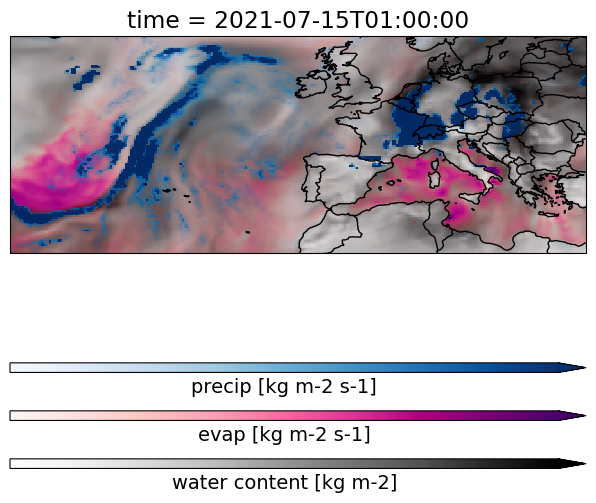

In [7]:
%matplotlib inline
fig = plt.figure()
plot_fancy(input, fig, 1)
plt.show()

/tmp/ipykernel_916/1464613766.py:19: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb + alpha - 1) / alpha


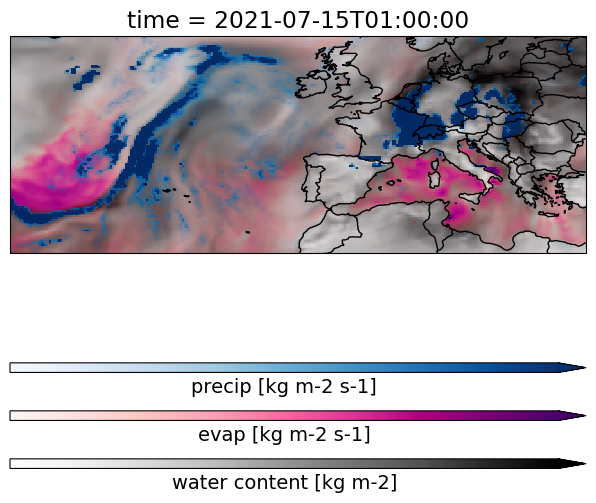

In [135]:
import cmocean

opacity=0.5

transport = (input.s_upper + input.s_lower).rename('water content')
transport.attrs['unit'] = "kg m-2"

cmap_transport = cm.gray_r
# cmap_transport = cmocean.tools.crop_by_percent(cmap_transport, 50, which='max', N=None)
# cmap_transport = cmocean.tools.lighten(cmap_transport, opacity)

precip = input.precip#.where(input.precip > 0)
evap = input.evap#.where(input.evap > 0)

cmap_evap = cm.ice_r
cmap_evap = cmocean.tools.crop_by_percent(cmap_evap, 30, which='max', N=None)
cmap_evap = cmocean.tools.lighten(cmap_evap, opacity)

cmap_precip = cm.amp
# cmap_precip = cmocean.tools.crop_by_percent(cmap_precip, 50, which='max', N=None)
cmap_precip = cmocean.tools.lighten(cmap_precip, opacity)


cmap_transport = custom_lighten_uniform(plt.get_cmap('Greys'))  # "cmo.rain", "Greys", 
cmap_evap = custom_lighten_uniform(plt.get_cmap('RdPu'))  # "Reds", "RdPu", "cmo.amp"
cmap_precip = custom_lighten_uniform(plt.get_cmap('Blues'))  # "cmo.ice_r", "cmo.dense", "Blues", 

cbar_kwargs = {'ticks': [], 'orientation': 'horizontal'}  #  'fraction': 0.05

# fig = plt.figure()
# ax = fig.add_subplot(111, projection=crs.PlateCarree())
fig = plt.figure()
ax = fig.add_axes([0.05, 0.35, 0.9, 0.75], projection=crs.PlateCarree())
cax3 = fig.add_axes([0.05, 0.25, 0.9, 0.02])
cax2 = fig.add_axes([0.05, 0.15, 0.9, 0.02])
cax1 = fig.add_axes([0.05, 0.05, 0.9, 0.02])

t = 1

transport.isel(time=t).plot(ax=ax, vmin=0, vmax=transport.quantile(.999).values, cmap=cmap_transport, cbar_kwargs={**cbar_kwargs, 'cax': cax1})
evap.isel(time=t).plot(ax=ax, vmin=0, vmax=evap.quantile(.999).values, cmap=cmap_evap, cbar_kwargs={**cbar_kwargs, 'cax': cax2})
precip.isel(time=t).plot(ax=ax, vmin=0, vmax=precip.quantile(0.95).values, cmap=cmap_precip, cbar_kwargs={**cbar_kwargs, 'cax': cax3})

ax.coastlines()
ax.add_feature(cf.BORDERS)
fig.subplots_adjust(hspace=0.01)

plt.show()



In [14]:
%matplotlib inline

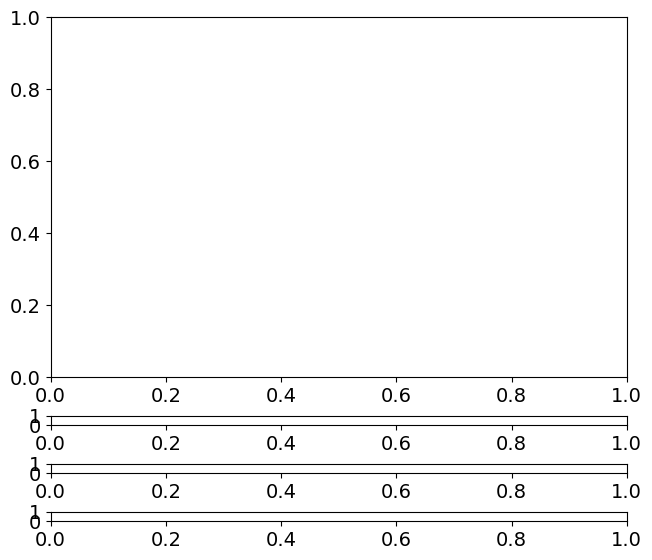

In [129]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.35, 0.9, 0.75])
cax3 = fig.add_axes([0.05, 0.25, 0.9, 0.02])
cax2 = fig.add_axes([0.05, 0.15, 0.9, 0.02])
cax1 = fig.add_axes([0.05, 0.05, 0.9, 0.02])
# fig.subplots_adjust()